# Use cases on beyond-accuracy perspectives - **Fairness**

---
## Get started

If you joined the Tutorial session late... Let's prepare our **workspace**!

The material is included in the [GitHub repository](https://github.com/beyondaccuracy-userprofiling/tutorial-cikm23) of the tutorial (expect for the raw datasets, due to upload limits of GitHub).

⭐ Star the repository if you are interested in this tutorial and its future updated versions.

To get started with the hands-on, follow these steps:

* Open the [Drive folder](https://drive.google.com/drive/folders/18Y0rKw_ORvOGcCw0eP6zaDdXRuTRb-Cf?usp=share_link) containing all the needed resources;
* Click on the folder name (`Hands-on`) and select *Add shortcut to Drive*;
* On the left, go to **My Drive**, locate the `Hands-on` folder;
* Open the notebook named `3_Fairness.ipynb` (and all the others for the next hands-on sessions);
* On the top, open the *Runtime* tab, click on *Change runtime type* and select **GPU** as the *Harware Acceleration*, to enable the execution of this notebook on a GPU (required for the GNN training);
* Download the [datasets](http://gofile.me/72h0u/qdRw7y26c) for the tutorial and put it in a `datasets` folder inside `Hands-on`.

### Mount the Drive

The first operation is to allow the notebook to access the hands-on files downloaded in your personal Google Drive folder.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
## Fairness metrics definition

We define the *fairness metrics* considering:

* $y \in \{0,1\}$ as the **binary target label**;
* $\hat{y} \in \{0,1\}$ as the **prediction**;
* $f: x \rightarrow y$ as the **user profiling model**.

### Disparate impact metrics

Also known as *adverse impact*, **disparate impact** refers to a form of indirect and often unintentional discrimination that occurs when practices or systems seem to apparently treat people the same way [(Hajan et al., 2016)](https://dl.acm.org/doi/pdf/10.1145/2939672.2945386?casa_token=P7m2abcd6xsAAAAA:DB-8FTCiz2z896snJUPO6SZhs2IV3bpmrvUVLH9muFDMEJ_YDaADHjBZQY-m3XDXA0PtGLpqJoq7).

It concerns with situations where the model disproportionately discriminates against certain groups, even if the model does not explicitly employ the sensitive attribute to make predictions but rather on some proxy attributes [(Wan et al., 2021)](https://arxiv.org/pdf/2111.03015.pdf).
This is exactly what happens in the analysed GNNs, where the user models are created by aggregating information from neighbours, and the sensitive attribute is not explicitly taken into consideration during classification.

The notion of disparate impact is beneficial when there is not a clear linkage in training data between the predicted label and the sensitive attribute, i.e. it is hard to define the validity of a decision for a group member based on the historical data [(Zafar et al., 2021)](https://dl.acm.org/doi/pdf/10.1145/3038912.3052660?casa_token=tcY1AXFoetUAAAAA:OI7tBqPKInbmV5l-TS4SLORWDrTQvuAOsirVFtJzF1oRv2kxmsz-s_TDQYQsI_AX61w0NdvEX35e).

#### Statistical parity (SP)

**Statistical parity** (also known as *demographic parity*) [(Dwork et al., 2012)](https://dl.acm.org/doi/pdf/10.1145/2090236.2090255?casa_token=kSl04UcXFEMAAAAA:7Z5WSQV4lMiQVHS9lcvXf5wkb4fTKCk5v_ROIGDUqSCSt4eX6hTVM3CYSG-jdtI9zHP3TX5jAqcG) [(Feldman et al., 2015)](https://dl.acm.org/doi/pdf/10.1145/2783258.2783311?casa_token=lqi7xZRnjmcAAAAA:zXay4-74GWYPU_txUN7n4IaqhGBUI1OrJ4k_MpBAJW5NwbB8LhVysxiEPy2EsJJiMgbVQ8gZc8Ii) defines fairness as an equal probability for each group of being assigned to the positive class, i.e. predictions independent with sensitive attributes.

$$
P(\hat{y} = 1~|~s = 0) = P(\hat{y} = 1~|~s = 1)
$$

#### Equal opportunity (EO)

**Equal opportunity** [(Hardt et al., 2016)](https://proceedings.neurips.cc/paper/2016/file/9d2682367c3935defcb1f9e247a97c0d-Paper.pdf) requires the probability of a subject in a positive class to be classified with the positive outcome should be equal for each group, i.e. *true positives* should be the same across groups.

$$
P(\hat{y} = 1~|~y = 1,~s = 0) = P(\hat{y} = 1~|~y = 1,~s = 1)
$$


#### Overall accuracy equality (OAE)

To extend the disparate impact evaluation commonly conducted, we can measure this metric to consider both *true positives* and *true negatives* and look at relative accuracy across the groups.

**Overall accuracy equality** [(Berk et al., 2021)](https://journals.sagepub.com/doi/pdf/10.1177/0049124118782533) defines fairness as the equal probability of a subject from either positive or negative class to be assigned to its respective class, i.e. each group should have the same prediction accuracy.

$$
P(\hat{y} = 0~|~y = 0,~s = 0) + P(\hat{y} = 1~|~y = 1,~s = 0) = P(\hat{y} = 0~|~y = 0,~s = 1) + P(\hat{y} = 1~|~y = 1,~s = 1)
$$

### Disparate mistreatment metrics

In a scenario where it is hard to define the correctness of a prediction related to sensitive attribute values, we argue that a complete fairness assessment should always include the perspective of **disparate mistreatment**.

This concept considers the *misclassification rates* for user groups having different values of the sensitive attribute, instead of considering the corrected predictions [(Zafar et al., 2021)](https://dl.acm.org/doi/pdf/10.1145/3038912.3052660?casa_token=tcY1AXFoetUAAAAA:OI7tBqPKInbmV5l-TS4SLORWDrTQvuAOsirVFtJzF1oRv2kxmsz-s_TDQYQsI_AX61w0NdvEX35e).

The notion of disparate mistreatment is significant in contexts where misclassification costs depend on the group affected by the error.

#### Treatment equality

**Treatment equality** [(Berk et al., 2021)](https://journals.sagepub.com/doi/pdf/10.1177/0049124118782533) requires the ratio of errors made by the classifier to be equal across different groups, i.e. each group should have the same ratio of *false negatives* and *false positives*.

$$
\frac{P(\hat{y} = 1~|~y = 0,~s = 0)}{P(\hat{y} = 0~|~y = 1,~s = 0)} = \frac{P(\hat{y} = 1~|~y = 0,~s = 1)}{P(\hat{y} = 0~|~y = 1,~s = 1)}
$$

### How to compute the fairness metrics

Before going into the code, we need to remind how we can solve the formulas of the metrics.

$$
P(A~|~B) = \frac{P(A \cap B)}{P(B)}
$$

$$
P(A~|~B,C) = \frac{P(A \cap B \cap C)}{P(B \cap C)}
$$

### Compute fairness metrics scores

The first step is defining the variables to use in the metrics for each specific model.

We need to define:

* Target class values $y$ (`true_y`);
* Prediction values $\hat{y}$ (`pred_y`);
* Sensitive attribute values $s$ (`sens_attr_values`)

```
# CatGCN

true_y = gnn_trainer.targets
pred_y = gnn_trainer.predictions
sens_attr_array = df_profile[sens_attr].values
sens_attr_values = sens_attr_array[test_nodes_idx]
```

```
# RHGN

true_y = numpy.asarray(model.targets)
pred_y = numpy.asarray(model.predictions)
sens_attr_array = G.nodes["user"].data[sens_attr].cpu().detach().numpy()
sens_attr_values = sens_attr_array[test_nodes_idx]
```

Let's define the other variables.

* $s = 0 \Rightarrow$ `s0 = sens_attr_values == 0`
* $s = 1 \Rightarrow$ `s1 = sens_attr_values == 1`
* $(y=1) \cap (s=0) \Rightarrow$ `y1_s0 = numpy.bitwise_and(true_y == 1, s0)`
* $(y=1) \cap (s=1) \Rightarrow$ `y1_s1 = numpy.bitwise_and(true_y == 1, s1)`
* $(y=0) \cap (s=0) \Rightarrow$ `y0_s0 = numpy.bitwise_and(true_y == 0, s0)`
* $(y=0) \cap (s=1) \Rightarrow$ `y0_s1 = numpy.bitwise_and(true_y == 0, s1)`

To quantitatively evaluate the disparate impact and disparate mistreatment of the analysed models, we operationalise the metrics as follows:

$$
\Delta_{SP} = | P(\hat{y} = 1~|~s = 0) - P(\hat{y} = 1~|~s = 1) |
$$

```
stat_parity = abs(sum(pred_y[s0]) / sum(s0) - sum(pred_y[s1]) / sum(s1))
```

$$
\Delta_{EO} = | P(\hat{y} = 1~|~y = 1,~s = 0) - P(\hat{y} = 1~|~y = 1,~s = 1) |
$$

```
equal_opp = abs(sum(pred_y[y1_s0]) / sum(y1_s0) - sum(pred_y[y1_s1]) / sum(y1_s1))
```

$$
\Delta_{OAE} = | P(\hat{y} = 0~|~y = 0,~s = 0) + P(\hat{y} = 1~|~y = 1,~s = 0) - P(\hat{y} = 0~|~y = 0,~s = 1) - P(\hat{y} = 1~|~y = 1,~s = 1) |
$$

```
oae_s0 = numpy.count_nonzero(pred_y[y0_s0] == 0) / sum(y0_s0) + sum(pred_y[y1_s0]) / sum(y1_s0)
oae_s1 = numpy.count_nonzero(pred_y[y0_s1] == 0) / sum(y0_s1) + sum(pred_y[y1_s1]) / sum(y1_s1)
oae_diff = abs(oae_s0 - oae_s1)
```

$$
\Delta_{TE} = \bigg | \frac{P(\hat{y} = 1~|~y = 0,~s = 0)}{P(\hat{y} = 0~|~y = 1,~s = 0)} - \frac{P(\hat{y} = 1~|~y = 0,~s = 1)}{P(\hat{y} = 0~|~y = 1,~s = 1)} \bigg |
$$

```
te_s0 = (sum(pred_y[y0_s0]) / sum(y0_s0)) / (numpy.count_nonzero(pred_y[y1_s0] == 0) / sum(y1_s0))
te_s1 = (sum(pred_y[y0_s1]) / sum(y0_s1)) / (numpy.count_nonzero(pred_y[y1_s1] == 0) / sum(y1_s1))
te_diff = abs(te_s0 - te_s1)
```

---
## Run the fairness experiments

In [ ]:
# Import libraries
import os

# Install missing libraries in Colab
!pip3 install pymetis
!pip3 install torch_geometric
!pip3 install torch_scatter
!pip3 install texttable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.1/327.1 kB 14.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 16.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=fd5d4cbc6da221afa8b22ef9b970a0eb012e9c001830dce16e4794e8d3089c26
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 kB 6.8 MB/s eta 0:00:00
  Preparing me

Concerning the parameters for running **CatGCN** and **RHGN**, there are in both cases, two additional attributes to consider:

* `--compute-fairness`: flag for computing the fairness metrics or not;
* `--sens-attr`: sensitive attribute for fairness metrics computation.

⚠️ We already prepared a script for running the models with a set of default parameter values.

### CatGCN

Set the model directory path.

In [ ]:
%cd /content/drive/MyDrive/Code/Research/tutorial-cikm23/Hands-on/models/CatGCN

💻 Run the script!

In [ ]:
%%shell
. ./scripts/test_alibaba_fairness.sh

+-------------------+----------------------------------+
|     Parameter     |              Value               |
+===================+==================================+
| Aggr pooling      | mean                             |
+-------------------+----------------------------------+
| Aggr style        | sum                              |
+-------------------+----------------------------------+
| Alpha             | 0.500                            |
+-------------------+----------------------------------+
| Balance ratio     | 0.700                            |
+-------------------+----------------------------------+
| Bi interaction    | nfm                              |
+-------------------+----------------------------------+
| Cluster number    | 100                              |
+-------------------+----------------------------------+
| Clustering method | none                             |
+-------------------+----------------------------------+
| Compute fairness  | 1        

### RHGN

Set the model directory path.

In [ ]:
%cd /content/drive/MyDrive/Code/Research/tutorial-cikm23/Hands-on/models/RHGN

💻 Run the script!

In [ ]:
%%shell
. ./scripts/test_jd_fairness.sh

### FairGNN

See the specific notebook [here](https://colab.research.google.com/drive/18nLSYCcY_lvFp-6wDIE6wUqfP4tYW7oU?usp=sharing).

---
## FairUP Framework

**FairUP** is a standardised framework that empowers researchers and practitioners to simultaneously analyse state-of-the-art *Graph Neural Network-based* models for *user profiling* task, in terms of classification performance and fairness metrics scores.

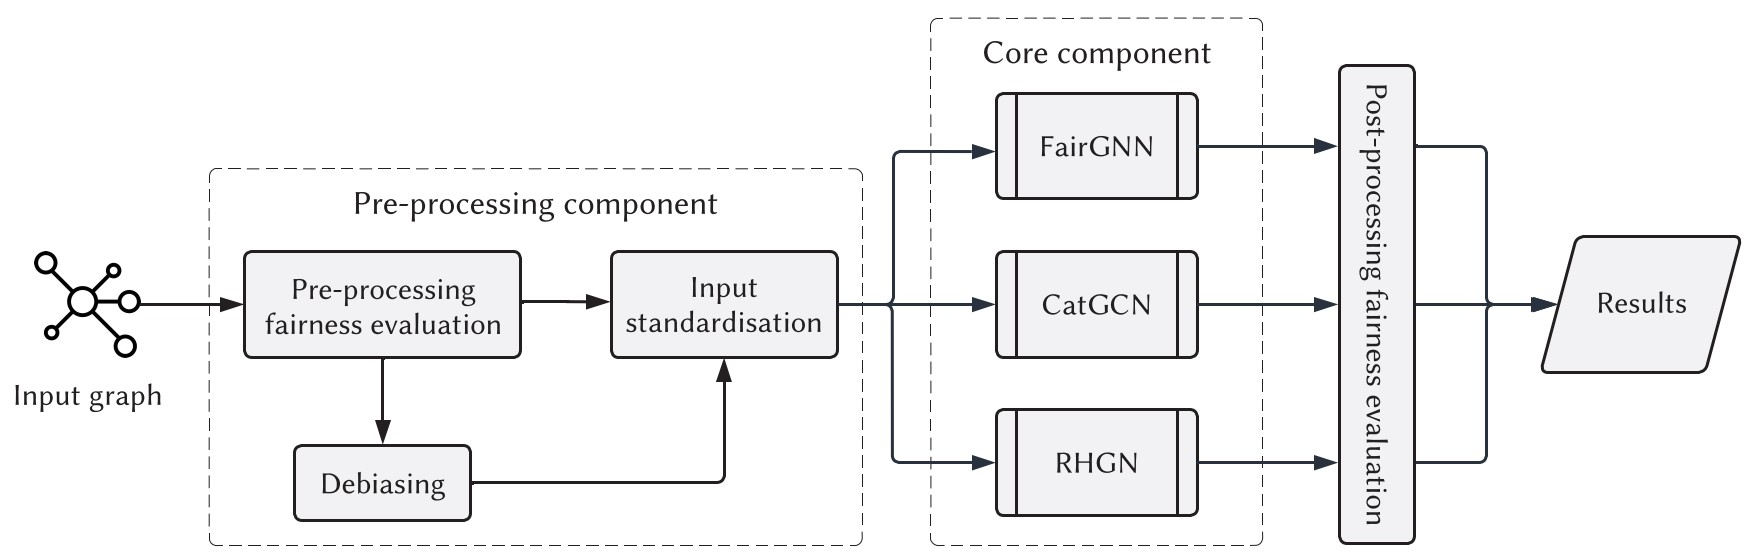

The framework, whose architecture is shown above, presents several components, which allow end-users to:

* compute the fairness of the input dataset by means of a pre-processing fairness metric, i.e. *disparate impact*;
* mitigate the dataset unfairness, if so, by applying different debiasing methods, i.e. *sampling*, *reweighting* and *disparate impact remover*;
* standardise the input (a graph in Neo4J or NetworkX format) for each of the included GNNs;
* train one or more GNN models, specifying the parameters for each of them;
* evaluate post-hoc fairness by exploiting four metrics, i.e. *statistical parity*, *equal opportunity*, *overall accuracy equality*, *treatment equality*.

🎥 [Demo video](https://bit.ly/FairUP-demo-video)